<a href="https://colab.research.google.com/github/badaldutt09/streamlit-example/blob/master/Research_Assistant_AI_with_PDFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Installs, Imports and API Keys

In [1]:
# RUN THIS CELL FIRST!
!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.4/648.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.6/276.6 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.5/471.5 kB 36.0 MB/s

In [4]:
!pip install openai

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [6]:
os.environ["OPENAI_API_KEY"] = "fe51611c5a00406baa1d7325c8684d87"

In [20]:
#importing open ai resource
import openai
import json
# Set OpenAI API configuration
openai.api_key = "fe51611c5a00406baa1d7325c8684d87"
openai.api_type ="azure"
openai.api_base = "https://iocl-oai.openai.azure.com/"
openai.api_version ="2023-07-01-preview"
engine="gpt_35_turbo_16k"

# 1. Loading PDFs and chunking with LangChain

In [ ]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages
loader = PyPDFLoader("/content/Global Oil and gas news.pdf")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content='Angola to maintain crude output at 1.1 million bpd into 2024  \n... not normally found with oil discoveries. The gas produced..., the chief \nexecutive of Azule Energy, Angola\'s largest private oil and gas...  \nOCTOBER 19, 2023 06:18AM EDT  \nResidents demonstrate against Royal Dutch Shell\'s plans to start seismic...  \nShell\'s court battle over S.Africa energy exploration delayed -lawyer \n... to allow Shell to explore for oil and gas off South Africa\'s pristine \nWild... Africa, a local unit of privately held Impact Oil and Gas...  \nOCTOBER 18, 2023 05:15AM EDT  \nNo gas finds after dri lling at Lebanon\'s offshore Block 9 -source \n..., meaning no oil or gas had been found. Block 9 is one of the blocks... \nminister had told Reuters on Wednesday. Lebanon hopes gas and oil...  \nOCTOBER 13, 2023 10:39AM EDT  \nUPDATE 1 -No gas finds after drilling at  Lebanon\'s offshore Block 9 -source \n... drilling, meaning no oil or gas had been found. Block 9 is one... \nener

In [16]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract

# List of PDF file paths
pdf_files = ["/content/Andaman Sea - Seismic Exploration De-Risking.pdf", "/content/SCOPE TOC-of-future-exploration-in-andaman-basin-jaipur-2015.pdf"]

# Iterate through each PDF and extract text
text = ""
for pdf_file in pdf_files:
    doc = textract.process(pdf_file)
    text += doc.decode('utf-8')

# Step 2: Save the extracted text to a single .txt file
with open('pdftext.txt', 'w', encoding='utf-8') as f:
    f.write(text)

# If you want to read the text from the file, you can do so:
with open('pdftext.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 1500,
    chunk_overlap  = 50,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

In [17]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0])
len(chunks)

10

Token indices sequence length is longer than the specified maximum sequence length for this model (1419 > 1024). Running this sequence through the model will result in indexing errors


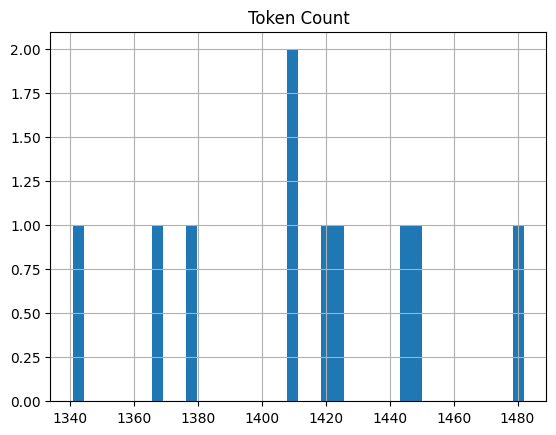

In [18]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

# 2. Embed text and store embeddings

In [21]:
import faiss
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

In [ ]:
db

# 3. Setup retrieval function

In [22]:
# Check similarity search is working
query = "What countries have oil and gas disocveries?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='© 2020 Society of Exploration Geophysicists\n\nSEG International Exposition and 90th Annual Meeting\n\n\x0c \n\nAndaman Sea - Seismic Exploration De-Risking \n\nlarge  carbonate  feature.  This  carbonate  platform  formed \nduring Late Oligocene and Early Miocene, drowned below \nsea-level  during  the  mid-Miocene.  By  contrast,  in  the \nCentral Andaman region, the reservoirs of the Yetagun Gas \nField are siliciclastics and the field is situated in the located \nin the back-arc region. In the southern part of Andaman Sea \nanother  major  carbonate  field  is  the  Arun  Gas  Field, \nstraddling  from  onshore  North  Sumatra  and  extending \noffshore. Still in the shallow waters off South Sumatra the \nNSO Field nearby is another discovery in the back-arc. . The \nfield  produces  from  Miocene  carbonates,  although  it  is  a \nsmaller carbonate platform when compared with the larger \nArun  gas  field,  a  giant  hydrocarbon  resource  that  has \ndeli

In [ ]:
# Set OpenAI API configuration
os.environ["OPENAI_API_KEY"] = "fe51611c5a00406baa1d7325c8684d87"
os.environ["Openai.Api_Type"] ="azure"
os.environ["Openai_Api_Base"] = "https://iocl-oai.openai.azure.com/"
os.environ["Openai_Api_Version"] ="2023-07-01-preview"
os.environ["Engine"]="gpt_35_turbo_16k"

In [23]:
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI


# 4. Integrating Similarity search with user Queries

In [24]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

engine="gpt_35_turbo_16k"
chain = load_qa_chain(ChatOpenAI(engine=engine, temperature=0.5, max_tokens=500),chain_type="stuff")

query = "What countries have oil and gas disocveries?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

'Based on the provided context, the Andaman Sea region has significant oil and gas discoveries. Specifically, the countries with oil and gas discoveries in the Andaman Sea include:\n\n1. Myanmar (Burma): The Yadana Gas Field and the Yetagun Gas Field are located offshore Myanmar in the Andaman Sea.\n\n2. Indonesia: The Arun Gas Field and the NSO Gas Field are located offshore North Sumatra in the Andaman Sea.\n\nThese discoveries have led to the production of natural gas, including the export of liquefied natural gas (LNG) to Asia.'

# 5. Chatbot with chat memory

In [25]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(ChatOpenAI(temperature=0.1, engine=engine), db.as_retriever())

In [27]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Research Assitant chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the Research Assitant chatbot! Type 'exit' to stop.


Text(value='', placeholder='Please enter your question:')

HTML(value='<b>User:</b> What are tectonic elements of Andaman Bsain')

HTML(value='<b><font color="blue">Chatbot:</font></b> The tectonic elements of the Andaman Basin include:\n\n1…

HTML(value='<b>User:</b> could you references of source of your information?')

HTML(value='<b><font color="blue">Chatbot:</font></b> The source of the information regarding the tectonic ele…